<center><h1>Step 0 - Preprocessing</h1></center> 

In this section, we first read the data including the bug reports and source code files of all 12 projects and for ease of access, we save them as two pickle files in the ./Data directory. Therefore, this set of code will populate the ./Data directory with "allBugReports.pickle" which is a pandas dataframe that contains all the bug reports from all projects and "allSourceCodes.pickle" which is a pandas dataframe that contains all source files after preprocessing.

### Required Libraries

In [2]:
!pip install javalang

In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from typing import Iterable, Union, Dict, Tuple
from IPython.core.display import display
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import minmax_scale
import warnings
import javalang
import re
import glob
import math
import time
from scipy import spatial
import scipy.spatial.distance
import xml.etree.ElementTree as ET
import requests
import multiprocessing
from tqdm.notebook import tqdm as tq
from time import gmtime, strftime
from random import randint
warnings.simplefilter(action='ignore', category=FutureWarning)

<center><h1>Splitting code and natural language</h1></center> 

<center><h1>Loading source codes into pandas Dataframe</h1></center> 

In [4]:
def classNames_methodNames(node):
    result=''
    if isinstance(node,javalang.tree.MethodDeclaration) or isinstance(node,javalang.tree.ClassDeclaration):
        return node.name.lower()+' '
    if not (isinstance(node,javalang.tree.PackageDeclaration) or
        isinstance(node,javalang.tree.FormalParameter) or
       isinstance(node,javalang.tree.Import)):
        if node:
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=classNames_methodNames(childNode)
    return result
    
def traverse_node(node,i=0):
    i+=1
    result=''
    if not(isinstance(node,javalang.tree.PackageDeclaration)
            or isinstance(node,javalang.tree.FormalParameter)            
            or isinstance(node,javalang.tree.Import)
            or isinstance(node,javalang.tree.CompilationUnit)):
        if node:
            if (isinstance(node,int) or isinstance(node,str) or isinstance(node,float)) and i==2:
                result+=node+' '
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=traverse_node(childNode,i)
    return result

def code_parser(code):
    try:
        tree = javalang.parse.parse(code)
        return ''.join([traverse_node(node) for path, node in tree]) + ' ' + ''.join([classNames_methodNames(node)
                                                                                      for path, node in tree])
    except Exception as e: 
        print(e)
        return ''


def loadSourceFiles2df(PATH,project):
    """
    Receives: group name and project name 
    Process: open the source file directory and finds all the java files,
             and after preprocessing(using code_preprocessor) load them into a pandas dataframe 
    Returns: dataframe >> "filename","code","size"
    """
    print('Loading source files of {}  ...'.format(project))
    PATH=os.path.join("data",project,"gitrepo")
    all_source_files=glob.glob(PATH+'/**/*.java', recursive=True)
    source_codes_df=pd.DataFrame([])
    sourceCodesList=[]

    for filename in tq(all_source_files):
        code=open(filename,encoding='ISO-8859-1').read()
        if 'src/' in filename:
            sourceCodesList.append(dict({"filename":filename.split('src/')[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
        else:
            sourceCodesList.append(dict({"filename":filename.split(project)[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
    source_codes_df=source_codes_df.append(pd.DataFrame(sourceCodesList))
    return source_codes_df

def load_all_SCs(dataPath):
    print('\tLoading all source codes ... ')
    source_codes_df=pd.DataFrame([])
    all_projects= [folder for folder in listdir(dataPath)]
    for project in all_projects:
        source_path=os.path.join(dataPath,project,"gitrepo")
        source_codes_df=source_codes_df.append(loadSourceFiles2df(source_path,project))
    return source_codes_df

<center><h1>Loading bug reports pandas Dataframe</h1></center> 

In [5]:
def loadBugs2df(PATH,project):
    """
    @Receives: the path to bug repository (the xml file)
    @Process: Parses the xml file and reads the fix files per bug id. 
    @Returns: Returns the dataframe
    """
    print("Loading Bug reports ... ")
    all_bugs_df=pd.DataFrame([],columns=["id","fix","text","fixdate"])
    bugRepo = ET.parse(PATH).getroot()
    buglist=[]                   
    for bug in tq(bugRepo.findall('bug')):
        bugDict=dict({"id":bug.attrib['id'],"fix":[],"fixdate":bug.attrib['fixdate']
                      ,"summary":None,"description":None,"project":project,"average_precision":0.0})
        for bugDetail in bug.find('buginformation'):
            if bugDetail.tag=='summary':
                bugDict["summary"]=bugDetail.text
            elif bugDetail.tag=='description':
                bugDict["description"]=bugDetail.text
        bugDict["fix"]=np.array([fixFile.text.replace('/','.').lower() for fixFile in bug.find('fixedFiles')])
        summary=str(bugDict['summary']) if str(bugDict['summary']) !=np.nan else ""
        description=str(bugDict['description']) if str(bugDict['description']) !=np.nan else ""
        buglist.append(bugDict)
    all_bugs_df=all_bugs_df.append(pd.DataFrame(buglist))
    return all_bugs_df.set_index('id')

def load_all_BRs(dataPath):
    print('\tLoading all bug reports ... ')
    all_bugs_df=pd.DataFrame([])
    all_projects= [folder for folder in listdir(dataPath)]
    for project in all_projects:
        data_path=os.path.join(dataPath,project,"bugrepo","repository.xml")
        all_bugs_df=all_bugs_df.append(loadBugs2df(data_path,project))
        print(len(all_bugs_df))
    return all_bugs_df



<center><h1>Main Preprocessing class</h1></center> 

In [6]:
class PreprocessingUnit:

    all_projects_source_codes=pd.DataFrame([])
    all_projects_bugreports=pd.DataFrame([])
    
    def __init__(self,dataPath):

        self.dataPath=dataPath
        self.dataFolder=os.path.join(os.getcwd(),'Output')
        if not os.path.exists(self.dataFolder):
            os.makedirs(self.dataFolder)
            
    def execute(self):

        self.loadEverything()

    def loadEverything(self):
        vectorize=False
        if PreprocessingUnit.all_projects_bugreports.empty:
            bugReportFile=os.path.join(self.dataFolder,'allBugReports.pickle')
            if not os.path.isfile(bugReportFile):
                PreprocessingUnit.all_projects_bugreports=load_all_BRs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_bugreports.to_pickle(bugReportFile)
            else: 
                PreprocessingUnit.all_projects_bugreports=pd.read_pickle(bugReportFile)
        print("*** All bug reports are are preprocessed and stored as: {} ***".format('/'.join(bugReportFile.split('/')[-2:])))

        if PreprocessingUnit.all_projects_source_codes.empty:
            sourceCodeFile=os.path.join(self.dataFolder,'allSourceCodes.pickle')
            if not os.path.isfile(sourceCodeFile):
                PreprocessingUnit.all_projects_source_codes=load_all_SCs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_source_codes.to_pickle(sourceCodeFile)
            else:
                PreprocessingUnit.all_projects_source_codes=pd.read_pickle(sourceCodeFile)
        print("*** All source codes are preprocessed and stored as: {} ***".format('/'.join(sourceCodeFile.split('/')[-2:])))
        

### MAIN

In [7]:
if __name__=="__main__":

    config={'DATA_PATH':os.path.join('data')}
    preprocessor=PreprocessingUnit(dataPath=config['DATA_PATH'])
    preprocessor.execute()
   

*** All bug reports are are preprocessed and stored as: Output/allBugReports.pickle ***
*** All source codes are preprocessed and stored as: Output/allSourceCodes.pickle ***


In [8]:
import pandas as pd
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    all_projects_bugreports = all_projects_bugreports[all_projects_bugreports['description'].notna()].reset_index()
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    all_projects_source_codes = all_projects_source_codes[all_projects_source_codes['unprocessed_code'].notna()]
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()
display(all_projects_bugreports.iloc[10])
display(all_projects_source_codes.iloc[10].unprocessed_code)

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


'/*\n * Copyright 2002-2012 the original author or authors.\n *\n * Licensed under the Apache License, Version 2.0 (the "License");\n * you may not use this file except in compliance with the License.\n * You may obtain a copy of the License at\n *\n *      http://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an "AS IS" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\npackage org.springframework.test.web.client;\n\nimport java.io.IOException;\n\nimport org.springframework.http.client.ClientHttpRequest;\n\n/**\n * A contract for matching requests to expectations.\n *\n * @author Craig Walls\n * @since 3.2\n */\npublic interface RequestMatcher {\n\n\t/**\n\t * Match the given request against some expectations.\n\t *\n\t * @par

<center><h1>Data Clean Up</h1></center> 

Step 1: Removing all the missing bug reports from the source code files.

In [9]:
def Remove_missing_bug_reports(all_projects_bugreports, all_projects_source_codes):
    #print(all_projects_source_codes["filename"])
    source_file = set(all_projects_source_codes["filename"].map(lambda fname:"org"+fname.partition("org")[2].replace("\\",".")).tolist())

    # store all bugreports
    no_missing_files = all_projects_bugreports.copy()

    # files in source code dataframe
    for index, row in no_missing_files.iterrows():
        no_missing_files.at[index, "fix"] = list(set(row['fix']).intersection(source_file))

    no_missing_files = no_missing_files[no_missing_files.fix.str.len()>0]
    return no_missing_files

Step 2: Cleaning Textual data. 
-    The stop words include all the ENGLISH_STOP_WORDS and the java_keywords in Bench4BL repository.
-    All alphabets are converted to lowercase
-    The camel case words are split into 2 separate words.

In [10]:
import keyword
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt 

%matplotlib inline

stemmer = SnowballStemmer("english")

java_keywords = ["abstract", "assert", "boolean", "break", "byte", "case", "catch", "char",
                 "class", "const", "continue", "default", "do", "double", "else", "enum",
                 "extends", "final", "finally", "float", "for", "goto", "if", "implements",
                 "import", "instanceof", "int", "interface", "long", "native", "new", "package",
                 "private", "protected", "public", "return", "short", "static", "strictfp",
                 "super", "switch", "synchronized", "this", "throw", "throws", "transient", "try",
                 "void", "volatile", "while", "false", "null", "true"]

stop_words = set(list(ENGLISH_STOP_WORDS) + java_keywords  + keyword.kwlist)

def clean_text(text):

    # split words and return them if it is not in the stop words list
    def WordList(all_text:str) ->Iterable[str]:
        for word in re.findall('[A-Z]*[a-z]+|[A-Z]{2,}', all_text):
            word_lower=word.lower()
            if word_lower not in stop_words:
                yield stemmer.stem(word_lower)

    text=' '.join(WordList(text))
    return text

Step 3: Processed Data
In this step, the goal is to obtain a cleaned data with no missing files. The two tables show the proccessed data.

In [11]:
def getProcessedData():
#->Tuple[Dict[str,pd.DataFrame],Dict[str,pd.DataFrame]]:
    
    #Obtain projects with their bug_reports and source_codes
    all_projects_bugreports,all_projects_source_codes=loadEverything()

    # Cleaning the data to remove missing bug_reports
    no_missing_files=Remove_missing_bug_reports(all_projects_bugreports,all_projects_source_codes)

    #Storing cleaned value into processed_description, processed_summary
    no_missing_files["processed_description"]=no_missing_files["description"].map(clean_text)
    no_missing_files["processed_summary"]=no_missing_files["summary"].map(clean_text)
    no_missing_files["processed_all"]=no_missing_files["processed_description"] + no_missing_files["processed_summary"]
    no_missing_files=no_missing_files[["fix","processed_all","project"]]
    display(no_missing_files)

    all_projects_source_codes["processed_code"]=all_projects_source_codes["unprocessed_code"].map(clean_text)
    all_projects_source_codes=all_projects_source_codes[["filename","processed_code","project"]]
    display(all_projects_source_codes)

    #The dictionary which stores the key as "project" and the values as the processed data dataframes
    valuesByName={}
    grouped_code=all_projects_source_codes.groupby(["project"])
    for project,files in no_missing_files.groupby(["project"]):
        valuesByName[project]=files, grouped_code.get_group(project)
    return valuesByName

ProjectData = getProcessedData()

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


,filename,processed_code,project
0,main.java.org.springframework.test.package-inf...,generic unit test support class org springfram...,SPR
1,main.java.org.springframework.test.assertthrow...,copyright origin author author licens apach li...,SPR
2,main.java.org.springframework.test.web.package...,helper class unit test base spring s web suppo...,SPR
3,main.java.org.springframework.test.web.modelan...,copyright origin author author licens apach li...,SPR
4,main.java.org.springframework.test.web.client....,copyright origin author author licens apach li...,SPR
...,...,...,...
471,test.org.apache.commons.collections.collection...,licens apach softwar foundat asf contributor l...,COLLECTIONS
472,test.org.apache.commons.collections.collection...,licens apach softwar foundat asf contributor l...,COLLECTIONS
473,test.org.apache.commons.collections.collection...,licens apach softwar foundat asf contributor l...,COLLECTIONS
474,test.org.apache.commons.collections.collection...,licens apach softwar foundat asf contributor l...,COLLECTIONS


<center><h1>Data Analysis and Methods 1, 2</h1></center> 

Step 1: Data Analysis
- Create a label matrix
- Row = bug report
- Column = source code
- Result: All the cells with 1 specifies a change in the file to fix a bug.
        All the cells with 0 specifies a change was NOT implemented

In [17]:
from scipy.sparse import lil_matrix

def getLabelsForBugReport()->Dict[str,np.ndarray]:
    def getLabelsForProject(processed_bug_report, processed_source_code):
    
        source_file=processed_source_code["filename"].map(lambda fname:"org"+fname.partition("org")[2].replace("\\","."))

        #Stores source file values according to an index (ID)
        file_index={}
        for index,value in enumerate(source_file.values):
            file_index[value]=index
        num_files=len(source_file)
        num_bug_reports=len(processed_bug_report["fix"])

        #Creating a label matrix
        matrix=lil_matrix((num_bug_reports,num_files))
        for index,file_names in enumerate(processed_bug_report["fix"]):
            for file_name in list(file_names):
                try:
                    matrix[index,file_index[file_name]]=1
                except KeyError:
                    pass
                    
        return matrix.toarray().astype(dtype=np.byte)

    return {project:(bugReport,sourceFile, getLabelsForProject(bugReport,sourceFile)) for project,(bugReport,sourceFile) in ProjectData.items()}


bugReportsCodeAndLabelsByProject=getLabelsForBugReport()
display(bugReportsCodeAndLabelsByProject["SPR"][2])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

<h2>Method 1</h2>
<p> Applying simply IRFL approach on the Bench4ML dataset. Applying TF-IDF method to calculate the similarity between
the new bug report and ther source files, directly.</br>
</p>

<h2>Method 2</h2>
<p> Using the same preprocessing and TF-IDF from Method , we calcuate an indirect relevancy function

In [18]:
from gensim import similarities
from gensim import corpora

def method_calls(processed_bug_report, processed_source_code, labels):

    # Create Tfidf vectorizer and fit using processed source code
    method1_vectorizer=TfidfVectorizer()
    method1_vector=method1_vectorizer.fit_transform(processed_source_code["processed_code"].to_numpy())

    # Transform bug reports using TF-IDF.
    def method1(bug_report):
        query=method1_vectorizer.transform(bug_report["processed_all"].to_numpy())
        result = cosine_similarity(query,method1_vector).astype(dtype=np.float32)
        return result

    # Probability is evaluted using the cosine similarity between source code and bug report outputs
    similarities1=method1(processed_bug_report)

    class Method2:
        def __init__(self,alpha=0.5):
            self.alpha=alpha
            self.bug_report_labels:Union[np.ndarray,None]=None
            self.tfidf:Union[TfidfVectorizer,None]=None
            self.bug_report_vector:Union[np.ndarray,None]=None
        
        def set_params(self,alpha):
            self.alpha=alpha

        def get_params(self,**kwargs):
            return {"alpha":self.alpha}

        # Create tf-idf vectorizer from previous bug reports
        def fit(self, X:pd.DataFrame, y:np.ndarray):
            self.bug_report_labels=y
            self.tfidf=TfidfVectorizer()
            self.bug_report_vector=self.tfidf.fit_transform(X["processed_all"].to_numpy())

        def getIndirectRelevancy(self,X:pd.DataFrame):
            query=self.tfidf.transform(X["processed_all"].to_numpy())
            similarity = cosine_similarity(query,self.bug_report_vector).astype(dtype=np.float32)
            n_files=self.bug_report_labels.sum(1)
            label_values_per_bug_report=similarity/n_files
            indirectRelevancy = label_values_per_bug_report.dot(self.bug_report_labels)
            return indirectRelevancy

        # Finds similarities between queries and previous bug reports
        def predict(self,X:pd.DataFrame)->np.ndarray:
            indirectRelevancy=minmax_scale(self.getIndirectRelevancy(X),axis=1)
            directRelevancy=minmax_scale(method1(X),axis=1)
            return (1-self.alpha)*directRelevancy+self.alpha*indirectRelevancy

    # Cross validation for training and testing data sets. Splits into 2 groups
    similarities2=cross_val_predict(Method2(alpha=0.25),processed_bug_report,labels,cv=2)

    return processed_bug_report,processed_source_code, labels, similarities1, similarities2


project_similarities={project: method_calls(bug_rep, src_code, lbls)
                      for project, (bug_rep,src_code, lbls) in bugReportsCodeAndLabelsByProject.items()}

Method 3: Using Latent Semantic Indexing (Described in Paper)

In [22]:
from gensim import similarities
from gensim import corpora
from gensim.models import LsiModel

def method_3(processed_bug_report, processed_source_code, labels):
    def method3():

        bug = [row.split() for row in processed_bug_report["processed_all"]]
        src= [row.split() for row in processed_source_code["processed_code"]]

        source_code_corpus = corpora.Dictionary(src)

        bug_bag = [source_code_corpus.doc2bow(line) for line in bug]
        source_bag = [source_code_corpus.doc2bow(line) for line in src]
        
        lsi = LsiModel(source_bag, id2word = source_code_corpus)
        similarity_matrix = similarities.MatrixSimilarity(lsi[source_bag])

        return similarity_matrix[lsi[bug_bag]]

    similarities3 = method3()
    processed_bug_report,processed_source_code, labels, similarities1, similarities2 = method_calls(processed_bug_report, processed_source_code, labels)

    return processed_bug_report,processed_source_code, labels, similarities1, similarities2, similarities3

project_similarities2 = {project: method_3(bug_rep, src_code, lbls)
                      for project, (bug_rep,src_code, lbls) in bugReportsCodeAndLabelsByProject.items()}

In [23]:
def MMRscore(denseLabels:np.ndarray, similarities:np.ndarray):
    # Filter the input labels to only include the label with the maximum similarity
    similarities_with_labels=denseLabels*similarities
    max_value_label_indexes=np.argmax(similarities_with_labels,axis=1)
    max_similar_labels=np.zeros_like(similarities_with_labels,dtype=np.byte)
    max_similar_labels[np.arange(len(similarities_with_labels)),max_value_label_indexes]=1

    # Calling label_ranking_average_precision_score with filtered input labels
    return label_ranking_average_precision_score(max_similar_labels,similarities)

In [26]:
def MAPscore(denseLabels:np.ndarray,similarities:np.ndarray):
    return label_ranking_average_precision_score(denseLabels,similarities)

In [27]:
# Calculates the mean of the scores of MMR and MAP for both methods.
#Conclusion: Method 2 has a higher MMR and MAP score than Method 1
def scoreBasics(processed_bug_report,processed_source_code, labels, similarities1, similarities2, similarities3):
    return {
        "mrr method1":MMRscore(labels,similarities1),
        "mrr method2":MMRscore(labels,similarities2),
        "mrr method3":MMRscore(labels,similarities3),
        "map method1":MAPscore(labels,similarities1),
        "map method2":MAPscore(labels,similarities2),
        "map method3":MAPscore(labels,similarities3)
    }
basicScores=pd.DataFrame((scoreBasics(*values) for values in project_similarities2.values()),index=project_similarities.keys())

averageScores=basicScores.mean()
display(averageScores)

mrr method1    0.483182
mrr method2    0.544180
mrr method3    0.466929
map method1    0.398779
map method2    0.453015
map method3    0.371344
dtype: float64

In [28]:
def get_top_k_indices(matrix, k):
    return np.argsort(matrix)[:,-k:][:,::-1]

# Calculates the MAP and MMR scores for the top 50 indices for both methods
def scoreTop50Indices()->Iterable[Dict]:
    top_indices_list = range(5,51,5)
    for project,(processed_bug_report,processed_source_code, labels, similarities1, similarities2, similarities3) in project_similarities2.items():
        for method_name,similarity in (("method1",similarities1),("method2",similarities2),("method3", similarities3)):
            indices = get_top_k_indices(similarity, 50)
            top_values=np.take_along_axis(similarity, indices,axis=1)
            top_labels=np.take_along_axis(labels, indices,axis=1)

            mrr={index:MMRscore(top_labels[:, :index], top_values[:,:index]) for index in top_indices_list}
            yield {"project":project, "method":method_name, "metric":"mrr", **mrr}

            map={index:MAPscore(top_labels[:, :index], top_values[:,:index]) for index in top_indices_list}
            yield {"project":project,"method":method_name, "metric":"map", **map}

top50Indices=pd.DataFrame(scoreTop50Indices())

Top50Indices=top50Indices.groupby(["metric","method"]).mean()
display(Top50Indices)

5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 
 
 metric 
 method 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 map 
 method1 
 0.778460 
 0.677135 
 0.627799 
 0.587783 
 0.564172 
 0.548917 
 0.522832 
 0.515912 
 0.505537 
 0.498050 
 
 
 method2 
 0.797976 
 0.684271 
 0.642062 
 0.603700 
 0.589764 
 0.570764 
 0.557452 
 0.549605 
 0.539900 
 0.535425 
 
 
 method3 
 0.803709 
 0.693048 
 0.640815 
 0.597955 
 0.569629 
 0.555239 
 0.535465 
 0.521049 
 0.507317 
 0.498586 
 
 
 mrr 
 method1 
 0.789852 
 0.704989 
 0.667949 
 0.633626 
 0.615502 
 0.603180 
 0.580769 
 0.575715 
 0.566927 
 0.561498 
 
 
 method2 
 0.815659 
 0.718919 
 0.686459 
 0.654142 
 0.645276 
 0.631098 
 0.619796 
 0.612798 
 0.605979 
 0.602480 
 
 
 method3 
 0.818262 
 0.724769 
 0.681798 
 0.649012 
 0.628710 
 0.617219 
 0.601270 
 0.591910 
 0.579646 
 0.572692

Plotting top K indices with respect to the MAP scores for both methods.

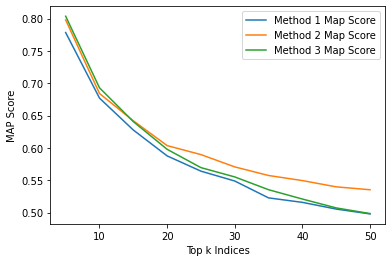

In [29]:
mapMethod1 = Top50Indices.iloc[0]
mapMethod2 = Top50Indices.iloc[1]
mapMethod3 = Top50Indices.iloc[2]
xLabels = [5,10,15,20,25,30,35,40,45,50]

fig, ax = plt.subplots()
plt.plot(xLabels, mapMethod1, label = "Method 1 Map Score")
plt.plot(xLabels, mapMethod2, label = "Method 2 Map Score")
plt.plot(xLabels, mapMethod3, label = "Method 3 Map Score")
plt.legend()
plt.ylabel("MAP Score")
plt.xlabel("Top k Indices")
plt.show()

Plotting top K indices with respect to the MMR scores for both methods.

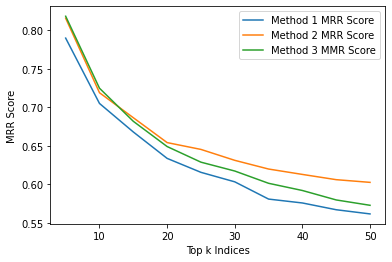

In [30]:
mrrMethod1 = Top50Indices.iloc[3]
mrrMethod2 = Top50Indices.iloc[4]
mmrMethod3 = Top50Indices.iloc[5]
xLabels = [5,10,15,20,25,30,35,40,45,50]

fig, ax = plt.subplots()
plt.plot(xLabels, mrrMethod1, label = "Method 1 MRR Score")
plt.plot(xLabels, mrrMethod2, label = "Method 2 MRR Score")
plt.plot(xLabels, mmrMethod3, label = "Method 3 MMR Score")
plt.legend()
plt.ylabel("MRR Score")
plt.xlabel("Top k Indices")
plt.show()